# **FLOW**

1. 연속형 변수(Income_total, Days_employed, Begin_month, Days_Birth) Minmax Scaling 적용
- Income_total : 4분위수에 근거하여 Outlier 를 Q1, Q3로 대체하였습니다.
- Days_employed : 실직을 뜻하는 양수 값은 0으로 대체하고 나머지 음수 값은 절대값을 취하여 양수로 전환하였습니다.
- Begin_month : 동일 인물로 추정되는 데이터 중 Begin_month 까지 동일한 데이터는 한개씩만 남겨두었습니다.
- Days_Birth : 절대값 /365를 나누고 int로 전환하여 나이를 의미하도록 만들었습니다.

2. 범주형 변수 PART.1(Gender, Car, Reality, income_type)

3. 범주형 변수 PART.2(Family_size, Child_num) 두 컬럼은 경향성이 존재하기 때문에 Ordinal Encoding을 적용했습니다.
- 

3. 파생 변수 


In [290]:
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
  
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, log_loss
from sklearn.cluster import KMeans

from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import StackingClassifier

from sklearn.pipeline import make_pipeline
from tqdm import tqdm

In [228]:
train = pd.read_csv('../Data/train.csv')
test = pd.read_csv('../Data/test.csv')
submission = pd.read_csv('../Data/sample_submission.csv')
sub_train = train

# **동월 카드를 2회 이상 발급한 경우 처리**

In [229]:
train['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) + str(n)  for i,j,k,l,m,n in zip(train['gender'],train['income_total'],train['income_type'],train['DAYS_BIRTH'],train['DAYS_EMPLOYED'], train['begin_month'])]
test['identity'] = [str(i) + str(j) + str(k) + str(l) + str(m) + str(n) for i,j,k,l,m,n in zip(test['gender'],test['income_total'],test['income_type'],test['DAYS_BIRTH'],test['DAYS_EMPLOYED'],test['begin_month'])]

print(f"train set 중복데이터가 아닌 사람의 수 : {sum(train['identity'].value_counts()==1)}명")
print(f"test set 중복데이터가 아닌 사람의 수 : {sum(test['identity'].value_counts()==1)}명")
print('-'*60)
print(f"train set 동일인물의 중복데이터로 추정되는 사람의 수 : {sum(train['identity'].value_counts()>=2)}명")
print(f"test set 동일인물의 중복데이터로 추정되는 사람의 수 : {sum(test['identity'].value_counts()>=2)}명")

train set 중복데이터가 아닌 사람의 수 : 21948명
test set 중복데이터가 아닌 사람의 수 : 9303명
------------------------------------------------------------
train set 동일인물의 중복데이터로 추정되는 사람의 수 : 2150명
test set 동일인물의 중복데이터로 추정되는 사람의 수 : 344명


In [230]:
subset = train['identity'].value_counts() > 1
subset

F135000.0Pensioner-20752365243-23.0               True
F315000.0Working-13064-2286-33.0                  True
F112500.0Working-13686-1256-2.0                   True
M148500.0Working-11819-962-3.0                    True
M216000.0Commercial associate-19150-7415-18.0     True
                                                 ...  
F90000.0Pensioner-23478365243-14.0               False
M202500.0Working-18281-3596-7.0                  False
F180000.0State servant-15972-5055-13.0           False
F157500.0Working-19176-2959-31.0                 False
F135000.0Pensioner-22504365243-3.0               False
Name: identity, Length: 24098, dtype: bool

In [231]:
drop_list = []

for i in range(len(subset)):
    if subset.values[i] == True:
        drop_list.append(subset.index[i])
    else:
        pass

In [232]:
for i in tqdm(range(len(drop_list))):
    train = train.drop(index = train.loc[train['identity'] == drop_list[i]].sort_values(by=['begin_month']).index[1:] , axis=0)

100%|██████████| 2150/2150 [00:18<00:00, 119.04it/s]


In [233]:
print(train.shape, "기존 dataframe의 shape는 (26457, 21) 였습니다.")

(24098, 21) 기존 dataframe의 shape는 (26457, 21) 였습니다.


In [234]:
train = train.drop('identity', axis = 1)
test = test.drop('identity', axis = 1)

# **Preprocessing**

In [235]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24098 entries, 0 to 26456
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          24098 non-null  int64  
 1   gender         24098 non-null  object 
 2   car            24098 non-null  object 
 3   reality        24098 non-null  object 
 4   child_num      24098 non-null  int64  
 5   income_total   24098 non-null  float64
 6   income_type    24098 non-null  object 
 7   edu_type       24098 non-null  object 
 8   family_type    24098 non-null  object 
 9   house_type     24098 non-null  object 
 10  DAYS_BIRTH     24098 non-null  int64  
 11  DAYS_EMPLOYED  24098 non-null  int64  
 12  FLAG_MOBIL     24098 non-null  int64  
 13  work_phone     24098 non-null  int64  
 14  phone          24098 non-null  int64  
 15  email          24098 non-null  int64  
 16  occyp_type     16683 non-null  object 
 17  family_size    24098 non-null  float64
 18  begin_

## **0. FLAG_MOBIL**

In [236]:
train['FLAG_MOBIL'] = train['FLAG_MOBIL'] - train['work_phone']*0.3 - train['phone']*0.3 - train['email']*0.3
test['FLAG_MOBIL'] = test['FLAG_MOBIL'] - test['work_phone']*0.3 - test['phone']*0.3 - test['email']*0.3

In [237]:
train['FLAG_MOBIL'].value_counts()

1.0    13253
0.7     7254
0.4     3341
0.1      250
Name: FLAG_MOBIL, dtype: int64

In [238]:
train['FLAG_MOBIL'] = train['FLAG_MOBIL'].replace([1,0.7,0.39999999999999997,0.09999999999999998], ['A','B','C','D'])
test['FLAG_MOBIL'] = test['FLAG_MOBIL'].replace([1,0.7,0.39999999999999997,0.09999999999999998], ['A','B','C','D'])

## **1. DAYS_EMPLOYED**

In [239]:
train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].value_counts()

365243    4059
Name: DAYS_EMPLOYED, dtype: int64

In [240]:
train.loc[train['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'] = 0
test.loc[test['DAYS_EMPLOYED'] > 0,'DAYS_EMPLOYED'] = 0

<AxesSubplot:ylabel='Frequency'>

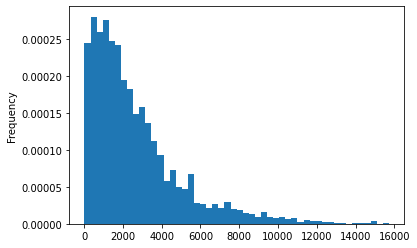

In [241]:
abs(train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED']).plot(kind='hist',bins=50,density=True)

In [242]:
train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'] = train.loc[train['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'].abs()
test.loc[test['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'] = test.loc[test['DAYS_EMPLOYED'] < 0,'DAYS_EMPLOYED'].abs()
train['DAYS_EMPLOYED']

0        4709
1        1540
2        4434
3        2092
4        2105
         ... 
26452    1984
26453    2475
26454    2015
26455     107
26456    1013
Name: DAYS_EMPLOYED, Length: 24098, dtype: int64

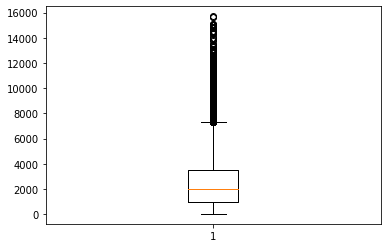

In [243]:
plt.boxplot(abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED']))
plt.show()

In [244]:
Q1 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.25))
Q2 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.50))
Q3 = abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED'].quantile(0.75))
IQR = Q3 - Q1

print(f'Q1 : {Q1} Q3 : {Q3} IQR : {IQR}')

Q1 : 969.0 Q3 : 3505.0 IQR : 2536.0


In [245]:
train.loc[(train['DAYS_EMPLOYED'] <= Q1 - 1.5 * IQR) | (train['DAYS_EMPLOYED'] >= Q3 + 1.5 *IQR), 'DAYS_EMPLOYED'] = Q3
test.loc[(test['DAYS_EMPLOYED'] <= Q1 - 1.5 * IQR) | (test['DAYS_EMPLOYED'] >= Q3 + 1.5 *IQR), 'DAYS_EMPLOYED'] = Q3

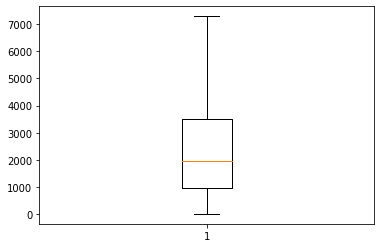

In [246]:
plt.boxplot(abs(train[train['DAYS_EMPLOYED'] > 0]['DAYS_EMPLOYED']))
plt.show()

In [247]:
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED']*100
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED']*100

In [248]:
train['DAYS_EMPLOYED'].value_counts()

0.0         4059
350500.0    1158
40100.0       53
153900.0      42
208700.0      39
            ... 
332500.0       1
682600.0       1
136200.0       1
77100.0        1
289700.0       1
Name: DAYS_EMPLOYED, Length: 3121, dtype: int64

## **2. BEGIN_MONTH**

<AxesSubplot:ylabel='Frequency'>

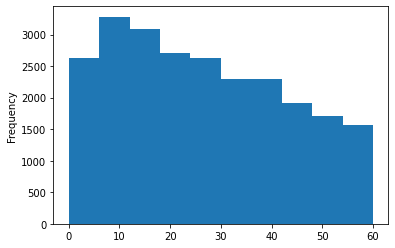

In [249]:
abs(train['begin_month']).plot(kind='hist', bins = 10)

In [250]:
train['begin_month'] = train['begin_month'].abs()
test['begin_month'] = test['begin_month'].abs()

In [251]:
train['begin_month'].value_counts()

7.0     599
3.0     547
6.0     545
5.0     545
11.0    544
       ... 
56.0    223
59.0    215
0.0     214
60.0    210
57.0    208
Name: begin_month, Length: 61, dtype: int64

## **3. INCOME_TOTAL**

<AxesSubplot:ylabel='Frequency'>

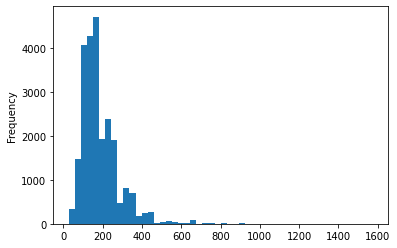

In [252]:
(train['income_total']/1000).plot(kind = 'hist', bins = 50)

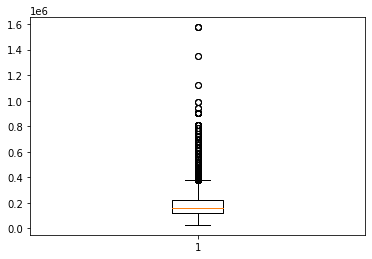

In [253]:
plt.boxplot(train['income_total'])
plt.show()

In [254]:
def box_value(col):
    Q1 = abs(train[train[col] > 0][col].quantile(0.25))
    Q2 = abs(train[train[col] > 0][col].quantile(0.50))
    Q3 = abs(train[train[col] > 0][col].quantile(0.75))
    IQR = Q3 - Q1

    return Q1, Q2, Q3, IQR

In [255]:
Q1 = box_value('income_total')[0]
Q2 = box_value('income_total')[1]
Q3 = box_value('income_total')[2]
IQR = box_value('income_total')[3]

In [256]:
train.loc[(train['income_total'] <= Q1 - 1.5 * IQR) | (train['income_total'] >= Q3 + 1.5 *IQR), 'income_total'] = Q3 + IQR/3
test.loc[(test['income_total'] <= Q1 - 1.5 * IQR) | (test['income_total'] >= Q3 + 1.5 *IQR), 'income_total'] = Q3 + IQR/3

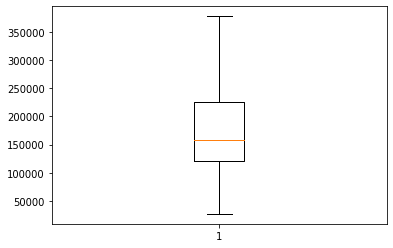

In [257]:
plt.boxplot(train['income_total'])
plt.show()

## **4. Gender**, **Car**, **Reality**

In [258]:
""" train['gender'] = train['gender'].replace(['F','M'],[0,1])
test['gender'] = test['gender'].replace(['F','M'],[0,1])
print('gender :')
print(train['gender'].value_counts())
print('--------------')

print('Having a car or not : ')
train['car'] = train['car'].replace(['N','Y'],[0,1])
test['car'] = test['car'].replace(['N','Y'],[0,1])
print(train['car'].value_counts())
print('--------------')

print('Having house reality or not: ')
train['reality'] = train['reality'].replace(['N','Y'],[0,1])
test['reality'] = test['reality'].replace(['N','Y'],[0,1])
print(train['reality'].value_counts())
print('--------------') """

" train['gender'] = train['gender'].replace(['F','M'],[0,1])\ntest['gender'] = test['gender'].replace(['F','M'],[0,1])\nprint('gender :')\nprint(train['gender'].value_counts())\nprint('--------------')\n\nprint('Having a car or not : ')\ntrain['car'] = train['car'].replace(['N','Y'],[0,1])\ntest['car'] = test['car'].replace(['N','Y'],[0,1])\nprint(train['car'].value_counts())\nprint('--------------')\n\nprint('Having house reality or not: ')\ntrain['reality'] = train['reality'].replace(['N','Y'],[0,1])\ntest['reality'] = test['reality'].replace(['N','Y'],[0,1])\nprint(train['reality'].value_counts())\nprint('--------------') "

## **5. DAYS_BIRTH**

In [259]:
train['DAYS_BIRTH'] = (train['DAYS_BIRTH'].abs()/365).astype(int)
test['DAYS_BIRTH'] = (test['DAYS_BIRTH'].abs()/365).astype(int)

<AxesSubplot:ylabel='Frequency'>

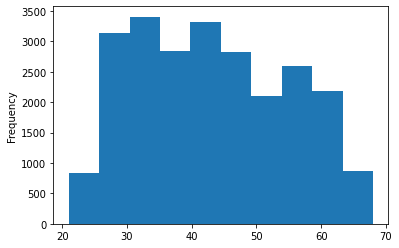

In [260]:
train['DAYS_BIRTH'].plot(kind='hist')

In [261]:
train['DAYS_BIRTH'].value_counts()

37    825
27    752
40    739
28    737
34    718
39    716
32    709
41    683
33    679
35    668
38    667
30    665
42    661
43    639
36    634
31    632
46    616
29    614
47    607
44    604
48    569
54    568
51    567
57    554
50    541
45    534
60    531
59    526
56    522
58    509
53    502
49    493
52    491
55    437
62    406
63    368
26    363
64    362
61    356
25    316
24    259
65    220
66    181
23    152
22    102
67     77
68     22
21      5
Name: DAYS_BIRTH, dtype: int64

## **6. family_size**

In [262]:
train['family_size'].value_counts()

2.0     12840
1.0      4631
3.0      4234
4.0      2074
5.0       266
6.0        38
7.0         9
15.0        3
9.0         2
20.0        1
Name: family_size, dtype: int64

In [263]:
test['family_size'].value_counts()

2.0    5357
1.0    1878
3.0    1789
4.0     846
5.0     106
6.0      14
7.0      10
Name: family_size, dtype: int64

In [264]:
train['family_size'] = train['family_size'].replace([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 4)
test['family_size'] = test['family_size'].replace([5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20], 4)

In [265]:
train['family_size'] = train['family_size'].replace({1 : 'A', 2 : 'B', 3 : 'C', 4 : 'D'})
test['family_size'] = test['family_size'].replace({1 : 'A', 2 : 'B', 3 : 'C', 4 : 'D'})

In [266]:
train['family_size'].value_counts()

B    12840
A     4631
C     4234
D     2393
Name: family_size, dtype: int64

## **7. work_phone**, **phone**, **email**, **FLAG_MOBIL**

In [267]:
train['work_phone'] = train['work_phone'].replace([0,1], ['N','Y'])
test['work_phone'] = test['work_phone'].replace([0,1], ['N','Y'])

train['phone'] = train['phone'].replace([0,1], ['N','Y'])
test['phone'] = test['phone'].replace([0,1], ['N','Y'])

train['email'] = train['email'].replace([0,1], ['N','Y'])
test['email'] = test['email'].replace([0,1], ['N','Y'])

## **8. CHILD_NUM & INCOME_CHILD(파생변수)**

In [268]:
train.loc[train['child_num'] > 3, 'child_num'] = 3
test.loc[test['child_num'] > 3, 'child_num'] = 3

In [269]:
train['income_child'] = train['income_total']/(train['child_num']+ 0.000001)
test['income_child'] = test['income_total']/(test['child_num'] + 0.000001)

In [270]:
def child_category(value):
    ep = ''
    if value == 0: ep = 'A'
    elif value == 1: ep = 'B'
    elif value == 2: ep = 'C'
    elif value >= 3: ep = 'D'
    
    return ep

In [271]:
train['child_num'] = train['child_num'].apply(lambda x : child_category(x))
test['child_num'] = test['child_num'].apply(lambda x : child_category(x))

In [272]:
train['child_num'].value_counts()

A    16659
B     4935
C     2167
D      337
Name: child_num, dtype: int64

## **9. OCCYP_TYPE**

In [273]:
def box_category(value):
    ep = ''
    if value <= Q1: ep = 0
    elif value <= Q2: ep = 1
    elif value <= Q3: ep = 2
    elif value > Q3: ep = 3
       
    return ep

train['income_box'] = train['income_total'].apply(lambda x : box_category(x))
test['income_box'] = test['income_total'].apply(lambda x : box_category(x))

In [274]:
train['occyp_type'] = train['occyp_type'].fillna('Secret')
test['occyp_type'] = test['occyp_type'].fillna('Secret')

subset = pd.crosstab(train['occyp_type'] , train['income_box'])
subset['Total'] = subset.sum(axis=1)

subset = subset.div(subset['Total'].values, axis = 0)
subset = subset.drop('Total', axis = 1)
subset = subset.drop('Secret', axis = 0)

kmeans = KMeans(n_clusters= 3)
kmeans.fit(subset)

KMeans(n_clusters=3)

In [275]:
subset['Cluster'] = kmeans.labels_ 

In [276]:
train['occyp_type'] = train['occyp_type'].replace('Secret' , 'A')
train['occyp_type'] = train['occyp_type'].replace(subset.loc[subset['Cluster'] == 2].index.values.tolist(),'B')
train['occyp_type'] = train['occyp_type'].replace(subset.loc[subset['Cluster'] == 1].index.values.tolist(), 'C')
train['occyp_type'] = train['occyp_type'].replace(subset.loc[subset['Cluster'] == 0].index.values.tolist(), 'D')

In [277]:
test['occyp_type'] = test['occyp_type'].replace('Secret' , 'A')
test['occyp_type'] = test['occyp_type'].replace(subset.loc[subset['Cluster'] == 2].index.values.tolist(),'B')
test['occyp_type'] = test['occyp_type'].replace(subset.loc[subset['Cluster'] == 1].index.values.tolist(), 'C')
test['occyp_type'] = test['occyp_type'].replace(subset.loc[subset['Cluster'] == 0].index.values.tolist(), 'D')

In [278]:
train['occyp_type'].value_counts()

D    10072
A     7415
C     4603
B     2008
Name: occyp_type, dtype: int64

In [279]:
test['occyp_type'].value_counts()

D    4032
A    3152
C    1955
B     861
Name: occyp_type, dtype: int64

In [280]:
train = train.drop('income_box', axis = 1)
test = test.drop('income_box', axis = 1)

# **데이터 중간 저장**

In [281]:
""" train.to_csv('../Data/Catdata.csv')
test.to_csv('../Data/Cattest.csv') """


" train.to_csv('../Data/Catdata.csv')\ntest.to_csv('../Data/Cattest.csv') "

In [282]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24098 entries, 0 to 26456
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   index          24098 non-null  int64  
 1   gender         24098 non-null  object 
 2   car            24098 non-null  object 
 3   reality        24098 non-null  object 
 4   child_num      24098 non-null  object 
 5   income_total   24098 non-null  float64
 6   income_type    24098 non-null  object 
 7   edu_type       24098 non-null  object 
 8   family_type    24098 non-null  object 
 9   house_type     24098 non-null  object 
 10  DAYS_BIRTH     24098 non-null  int32  
 11  DAYS_EMPLOYED  24098 non-null  float64
 12  FLAG_MOBIL     24098 non-null  object 
 13  work_phone     24098 non-null  object 
 14  phone          24098 non-null  object 
 15  email          24098 non-null  object 
 16  occyp_type     24098 non-null  object 
 17  family_size    24098 non-null  object 
 18  begin_

# **ENCODING**

## **1. Scaling**

In [283]:
scaler = MinMaxScaler()

train['income_total'] = scaler.fit_transform(train['income_total'].values.reshape(-1,1))
test['income_total'] = scaler.transform(test['income_total'].values.reshape(-1,1))

In [284]:
train['income_child'] = scaler.fit_transform(train['income_child'].values.reshape(-1,1))
test['income_child'] = scaler.transform(test['income_child'].values.reshape(-1,1))

## **2. ORDINAL ENCODING**

In [285]:
encoder = OrdinalEncoder()
encoder.fit(train[['child_num','family_size']])

train[['child_num','family_size']] = encoder.transform(train[['child_num','family_size']])
encoder.categories_

[array(['A', 'B', 'C', 'D'], dtype=object),
 array(['A', 'B', 'C', 'D'], dtype=object)]

In [286]:
test[['child_num','family_size']] = encoder.transform(test[['child_num','family_size']])
encoder.categories_

[array(['A', 'B', 'C', 'D'], dtype=object),
 array(['A', 'B', 'C', 'D'], dtype=object)]

## **3.ONE-HOT ENCODING**

In [287]:
train_x=train.drop(['credit','index'], axis=1)
train_y=train[['credit']]
test_x=test.drop('index', axis =1)

In [288]:
train_x = pd.get_dummies(train_x, drop_first= True)
test_x = pd.get_dummies(test_x, drop_first= True)

In [289]:
print(train_x.shape, test_x.shape, train_y.shape)

(24098, 36) (10000, 36) (24098, 1)


# **MODELING**

In [ ]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVC(random_state=42)))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42
)
clf.fit(X_train, y_train).score(X_test, y_test)

In [306]:
estimators = [
    ('rf', RandomForestClassifier(n_estimators=10, random_state = 2021)),
    ('svr', make_pipeline(StandardScaler(),
                          LinearSVC(random_state = 2021))),
    ('cat', CatBoostClassifier(random_state = 2021)),
    ('LGB', LGBMClassifier(random_state = 2021)),
    ('XGB', XGBClassifier(random_state = 2021))
]
clf = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression()
)
X_train, X_val, y_train, y_val = train_test_split(train_x, train_y, 
                                                    stratify=train_y, test_size=0.25,
                                                    random_state = 2021)
clf.fit(X_train, y_train).score(X_val, y_val)

Learning rate set to 0.091713
0:	learn: 1.0453574	total: 17ms	remaining: 17s
1:	learn: 1.0035155	total: 22.9ms	remaining: 11.4s
2:	learn: 0.9701228	total: 29.8ms	remaining: 9.89s
3:	learn: 0.9426484	total: 36.7ms	remaining: 9.13s
4:	learn: 0.9199921	total: 45.6ms	remaining: 9.07s
5:	learn: 0.9013882	total: 51.7ms	remaining: 8.56s
6:	learn: 0.8854258	total: 60.2ms	remaining: 8.54s
7:	learn: 0.8718804	total: 67.1ms	remaining: 8.32s
8:	learn: 0.8607699	total: 75.6ms	remaining: 8.33s
9:	learn: 0.8515198	total: 82.7ms	remaining: 8.19s
10:	learn: 0.8432036	total: 91.2ms	remaining: 8.2s
11:	learn: 0.8362737	total: 98.9ms	remaining: 8.14s
12:	learn: 0.8302141	total: 108ms	remaining: 8.19s
13:	learn: 0.8251777	total: 115ms	remaining: 8.07s
14:	learn: 0.8213427	total: 125ms	remaining: 8.19s
15:	learn: 0.8177810	total: 132ms	remaining: 8.13s
16:	learn: 0.8144519	total: 141ms	remaining: 8.17s
17:	learn: 0.8114687	total: 148ms	remaining: 8.1s
18:	learn: 0.8088324	total: 157ms	remaining: 8.12s
19:	l

0.7077178423236514

In [307]:
y_pred = clf.predict_proba(test_x)
y_pred.shape

(10000, 3)

In [308]:
y_val_pred = clf.predict_proba(X_val)

In [309]:
from tensorflow.keras.utils import to_categorical

print(f"log_loss: {log_loss(to_categorical(y_val['credit']), y_val_pred)}")

log_loss: 0.739851572268716


In [301]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(cat_pred, X_val, y_val)
plt.show()

ValueError: plot_confusion_matrix only supports classifiers

In [313]:
submission.loc[:,1:] = y_pred

In [314]:
submission

,index,0,1,2
0,26457,0.084416,0.185992,0.729592
1,26458,0.110311,0.144395,0.745294
2,26459,0.057076,0.099067,0.843857
3,26460,0.097924,0.133859,0.768218
4,26461,0.105356,0.213107,0.681537
...,...,...,...,...
9995,36452,0.095043,0.133251,0.771706
9996,36453,0.145757,0.329221,0.525022
9997,36454,0.056950,0.123458,0.819592
9998,36455,0.241277,0.123452,0.635271


In [315]:
submission.to_csv('../Data/LJH_stacking_2.csv', index=False)